In [22]:
# pip install tensorflow

In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

In [24]:
# Reading the data 
df = pd.read_csv("./dataset/spam.csv",encoding='latin-1') 
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [25]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1) 
df = df.rename(columns={'v1':'label','v2':'Text'}) 
df['label_enc'] = df['label'].map({'ham':0,'spam':1}) 
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


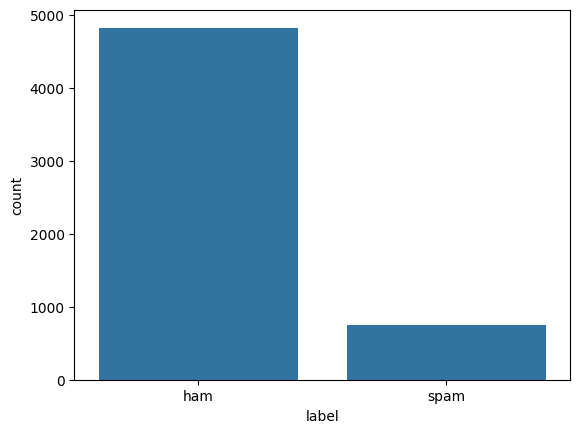

In [26]:
sns.countplot(x=df['label']) 
plt.show()


In [27]:
# Find average number of tokens in all sentences 
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text'])) 
print(avg_words_len)


15


In [28]:
# Finding Total no of unique words in corpus 
s = set() 
for sent in df['Text']: 
    for word in sent.split(): 
        s.add(word) 
total_words_length=len(s) 
print(total_words_length)


15585


In [29]:
# Splitting data for Training and testing 
from sklearn.model_selection import train_test_split 

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc']) 
new_df = pd.DataFrame({'Text': X, 'label': y}) 
X_train, X_test, y_train, y_test = train_test_split( 
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape 


((4457,), (4457,), (1115,), (1115,))

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report,accuracy_score 

tfidf_vec = TfidfVectorizer().fit(X_train) 
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test) 

baseline_model = MultinomialNB() 
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [31]:
# nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
# print(nb_accuracy)
# print(classification_report(y_test, baseline_model.predict(X_test_vec)))

In [32]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, baseline_model.predict(X_test_vec))

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score 

def compile_model(model): 
	''' 
	simply compile the model with adam optimzer 
	'''
	model.compile(optimizer=keras.optimizers.Adam(), 
				loss=keras.losses.BinaryCrossentropy(), 
				metrics=['accuracy']) 

def fit_model(model, epochs, X_train=X_train, y_train=y_train, 
			X_test=X_test, y_test=y_test): 
	''' 
	fit the model with given epochs, train 
	and test data 
	'''
	history = model.fit(X_train, 
						y_train, 
						batch_size=64,
						epochs=epochs, 
						validation_data=(X_test, y_test), 
						validation_steps=int(0.2*len(X_test))) 
	return history 

def evaluate_model(model, X, y): 
	''' 
	evaluate the model and returns accuracy, 
	precision, recall and f1-score 
	'''
	y_preds = np.round(model.predict(X)) 
	y_preds
	accuracy = accuracy_score(y, y_preds) 
	precision = precision_score(y, y_preds) 
	recall = recall_score(y, y_preds) 
	f1 = f1_score(y, y_preds) 

	model_results_dict = {'accuracy': accuracy, 
						'precision': precision, 
						'recall': recall, 
						'f1-score': f1} 

	return model_results_dict 


In [34]:
from tensorflow.keras.layers import TextVectorization 

MAXTOKENS=total_words_length 
OUTPUTLEN=avg_words_len 

text_vec = TextVectorization( 
	max_tokens=MAXTOKENS, 
	standardize='lower_and_strip_punctuation', 
	output_mode='int', 
	output_sequence_length=OUTPUTLEN 
) 
text_vec.adapt(X_train)


In [35]:
sample_sentense = 'This is a message'
text_vec([sample_sentense])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [36]:
embedding_layer = layers.Embedding( 
	input_dim=MAXTOKENS, 
	output_dim=64, 
	embeddings_initializer='uniform', 
	input_length=OUTPUTLEN 
) 


c:\Users\ssharma\AppData\Local\miniforge3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) 
vec_layer = text_vec(input_layer) 
embedding_layer_model = embedding_layer(vec_layer) 
x = layers.GlobalAveragePooling1D()(embedding_layer_model) 
x = layers.Flatten()(x) 
x = layers.Dense(32, activation='relu')(x) 
output_layer = layers.Dense(1, activation='sigmoid')(x) 
model_1 = keras.Model(input_layer, output_layer) 

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy( 
	label_smoothing=0.5), metrics=['accuracy']) 


In [38]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 64)         │       997,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,553 (3.81 MB)

 Trainable params: 999,553 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
compile_model(model_1) # compile the model 
history_1 = fit_model(model_1, epochs=5) # type: ignore # fit the model

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8137 - loss: 0.5178 - val_accuracy: 0.8915 - val_loss: 0.2503
Epoch 2/5
 8/70 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9232 - loss: 0.2117 

c:\Users\ssharma\AppData\Local\miniforge3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9325 - loss: 0.2025 - val_accuracy: 0.9623 - val_loss: 0.1540
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9763 - loss: 0.1030 - val_accuracy: 0.9713 - val_loss: 0.1034
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9866 - loss: 0.0537 - val_accuracy: 0.9758 - val_loss: 0.0836
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9904 - loss: 0.0378 - val_accuracy: 0.9785 - val_loss: 0.0822


<Axes: >

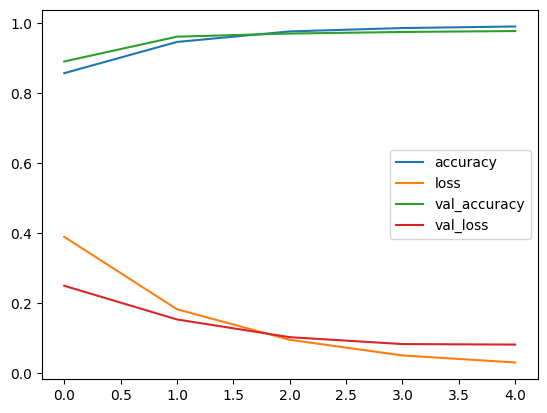

In [40]:
pd.DataFrame(history_1.history).plot()

In [41]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) 
vec_layer = text_vec(input_layer) 
embedding_layer_model = embedding_layer(vec_layer) 
bi_lstm = layers.Bidirectional(layers.LSTM( 
	64, activation='tanh', return_sequences=True))(embedding_layer_model) 
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm) 
flatten = layers.Flatten()(lstm) 
dropout = layers.Dropout(.1)(flatten) 
x = layers.Dense(32, activation='relu')(dropout) 
output_layer = layers.Dense(1, activation='sigmoid')(x) 
model_2 = keras.Model(input_layer, output_layer) 

compile_model(model_2) # compile the model 
history_2 = fit_model(model_2, epochs=5) # fit the model 


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.9333 - loss: 0.2096 - val_accuracy: 0.9785 - val_loss: 0.0859
Epoch 2/5
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9905 - loss: 0.0439

c:\Users\ssharma\AppData\Local\miniforge3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9954 - loss: 0.0200 - val_accuracy: 0.9803 - val_loss: 0.0966
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9950 - loss: 0.0176 - val_accuracy: 0.9812 - val_loss: 0.0929
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9984 - loss: 0.0096 - val_accuracy: 0.9821 - val_loss: 0.0949
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9821 - val_loss: 0.1041


In [42]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test) 
model_1_results = evaluate_model(model_1, X_test, y_test) 
model_2_results = evaluate_model(model_2, X_test, y_test) 

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results, 
							'Custom-Vec-Embedding Model':model_1_results, 
							'Bidirectional-LSTM Model':model_2_results}).transpose() 

total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.977578,0.977099,0.853333,0.911032
Bidirectional-LSTM Model,0.982063,0.971014,0.893333,0.930556


In [ ]:
evaluate_model(baseline_model, ['Free entry in 2 a wkly comp to win FA Cup'], [0])